In [58]:
import pandas as pd
import numpy as np
import pickle

In [59]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image

In [60]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
pickled_model = pickle.load(open('/content/drive/MyDrive/ML_Project_Sem5/Final_Submission/Facial_Recognition_Human_Mood/last_model', 'rb'))

In [62]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


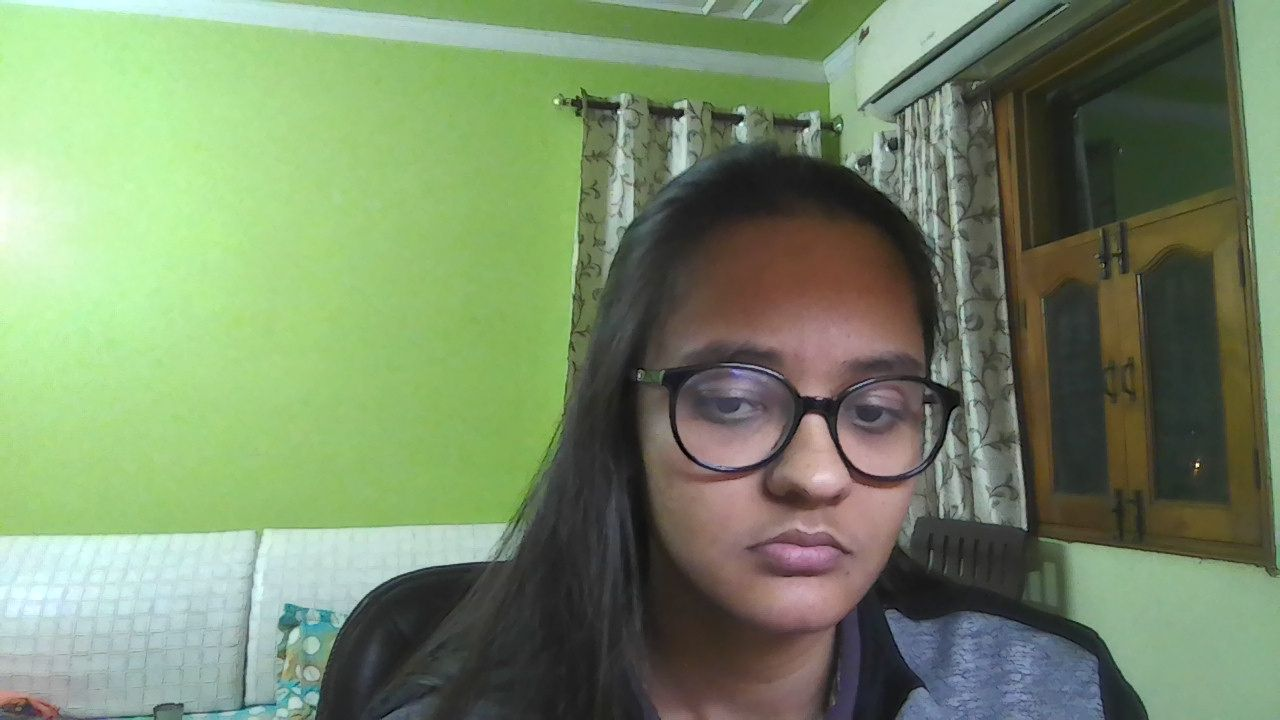

In [63]:
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  display(Image(filename))
except Exception as err:
  print(str(err))

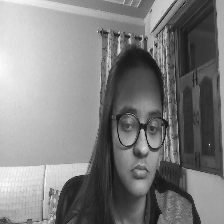

(224, 224, 3)


In [64]:
image_arr=[]
a1 = cv2.imread('photo.jpg')
image = cv2.resize(a1, (224, 224))
grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(grayscale)
print(image.shape)

In [65]:
print(np.shape(grayscale))
grayscale = np.repeat(grayscale[:, :, np.newaxis], 3, axis=2)
print(np.shape(grayscale))

(224, 224)
(224, 224, 3)


In [66]:
ans=pickled_model.predict(np.array(grayscale).reshape(-1,224,224,3))
temp=0
predicted_label=0
if(ans[0][1]>0.5):
  temp=ans[0][1]
  predicted_label=1
else:
  temp=1-ans[0][0]

1/1 [==============================] - 1s 684ms/step


In [67]:
print('Predicted_Label:',predicted_label,'\nHuman Mood Score:', temp,"\nSad and Happy Probabilities:",ans[0])

Predicted_Label: 0 
Human Mood Score: 0.23068439960479736 
Sad and Happy Probabilities: [0.7693156  0.23068446]


In [68]:
user_id = input('Enter id of the user: ')

Enter id of the user: user_3


In [70]:
user_playlist = pd.read_csv('drive/MyDrive/ML_Project_Sem5/Final_Submission/CSV_Files/Users_with_fav_genre.csv')
songs_emotion = pd.read_csv('drive/MyDrive/ML_Project_Sem5/Final_Submission/CSV_Files/songs_with_emotion_score.csv')

In [71]:
#user info
fav_genre = np.array(user_playlist[user_playlist['User ID']==user_id]['Fav Genre'])[0]
print('User favourite genre:',fav_genre)
human_mood_score = ans[0][1]
print('User human mood score:', human_mood_score)

#recommender
fav_genre_songs = songs_emotion[songs_emotion['Genre']==fav_genre]
fav_genre_songs = fav_genre_songs[fav_genre_songs['Happy_score']>=human_mood_score]
fav_genre_songs.sort_values(by=['Happy_score'], inplace=True)
if(len(fav_genre_songs)==0):
  print('You are already on the top of the world! Enjoy your life! Listen to any song of your choice!')
else:
  songs_score = np.array(fav_genre_songs['Happy_score'])
  max_score = max(songs_score)
  temp = (max_score - human_mood_score)/5
  playlist = []
  for i in range(5):
    temp_score = human_mood_score + (i+1)*temp
    z = fav_genre_songs.iloc[(fav_genre_songs['Happy_score']-temp_score).abs().argsort()[:2]]
    z.sort_values(by=['Happy_score'], inplace=True)
    playlist.append([z.iloc[0]['Song Name'], z.iloc[0]['Artist Name']])

  #songs recommended
  print('\nListen to: ')
  for s in playlist:
    print('Song:',s[0],'By:',s[1])
  print()

User favourite genre: rock
User human mood score: 0.23068446

Listen to: 
Song: Hungry Like the Wolf - 2009 Remaster By: Duran Duran
Song: Sweater Weather By: The Neighbourhood
Song: Chelsea Dagger By: The Fratellis
Song: Layla By: Derek & The Dominos
Song: Delusions of Saviour By: Slayer



/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
